# Train a model to estimate the vertices in an image

Predict Vertices position for Rectangles.    
Using Supervised Learning with Tensorflow

Data is received in 3 pickles that contains:
- Train images and labels (vertices)
- Validation images and labels (vertices)
- Test images and labels (vertices)

---
Francois Robert

In [1]:
# This notebook estimates the vertices for 1 shape
shape = "rectangle"

In [2]:
### Load packages
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import os
from pathlib import Path

from six.moves import cPickle as pickle

In [3]:
# More packages
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Our modules
from hds_module.shape_utils import HdsDataGenerator, calculate_Dice, calculate_Dice_for_set  
from hds_module.utils import ShowBestEpochResult

import datetime
datetime.datetime.now()

datetime.datetime(2022, 5, 28, 14, 14, 8, 764965)

In [4]:
# GPU Setting
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
from platform import python_version
print(f'Python: {python_version()}')

Python: 3.8.5


In [6]:
import tensorflow as tf
print(f'Tensorflow: {tf.__version__}')

Tensorflow: 2.3.1


In [7]:
seed1=127
np.random.seed(seed1)

## Define environment variables

In [8]:
BASEDIR = ".."

DATADIR = os.path.join(BASEDIR, "pickles")

TRAIN_DATAFILE = os.path.join(DATADIR, f"train_{shape}.pickle")
VAL_DATAFILE   = os.path.join(DATADIR, f"val_{shape}.pickle")
TEST_DATAFILE  = os.path.join(DATADIR, f"test_{shape}.pickle")

MODEL_DIR      = os.path.join(BASEDIR, "saved_models")
model_name     = os.path.join(MODEL_DIR, f"{shape}1.model") 

In [9]:
# Set image properties
image_size  = 70     # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [10]:
# Create model directory
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

## Load train, validation and test datasets from Pickles

In [11]:
with open(TRAIN_DATAFILE, 'rb') as file:
    train_dict = pickle.load(file)
with open(VAL_DATAFILE, 'rb') as file:
    val_dict = pickle.load(file)
with open(TEST_DATAFILE, 'rb') as file:
    test_dict = pickle.load(file)

In [12]:
# Load params used in ETL
params_dict = train_dict['params']

etl_shape = params_dict['shape']
nb_vertices = params_dict['nb_vertices']
anchor_x = params_dict['anchor_x']
anchor_y = params_dict['anchor_y']

print(f"{shape=}, {nb_vertices=}, {anchor_x=}, {anchor_y=}") 

assert shape == etl_shape, f"Invalid shape read. Expected: {shape}. Actual {etl_shape}."

shape='rectangle', nb_vertices=4, anchor_x=0.2, anchor_y=1.0


In [13]:
# Construct train set
train_X = train_dict['train_data']
train_y = train_dict['train_labels']

In [14]:
# Construct validation set
val_X = val_dict['val_data']
val_y = val_dict['val_labels']

In [15]:
print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)

train_X shape:  (5386, 70, 70)
train_y shape:  (5386, 8)


In [16]:
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

val_X shape:  (1391, 70, 70)
val_y shape:  (1391, 8)


In [17]:
# Reshape each image in 3 dimensions (height = 70px, width = 70px, canal = 1)
X_train = train_X.reshape(-1, image_size, image_size, 1)
X_val   = val_X.reshape(-1, image_size, image_size, 1)

In [18]:
Y_train = train_y
Y_val = val_y

In [19]:
X_train.shape

(5386, 70, 70, 1)

In [20]:
X_val.shape

(1391, 70, 70, 1)

In [21]:
# We expect to have 8 values for the labels of a rectangle.

In [22]:
Y_train.shape

(5386, 8)

In [23]:
Y_val.shape

(1391, 8)

In [24]:
# Labels are vertices: x1, y1, x2, y2, x3, y3, y4, y4
# Where:
# - (0, 0) is the top left corner of the image
# - (1, 1) is the bottom right corner of the image
print("Real Label example: ", Y_val[0])

Real Label example:  [0.28 0.87 0.27 0.13 0.77 0.12 0.78 0.88]


## Let's visualize the data
An image is worth a thousand words.

In [25]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [26]:
def plot_sample(X, y, axs):
    axs.imshow(X.reshape(image_size, image_size), cmap="gray") # Put the Image
    y = y.ravel()
    axs.scatter(image_size * y[0::2], image_size * y[1::2], c='orange') # Add the labels as orange dots

In [27]:
# This function shows images with their real vertices
# Presentation is rows of 10 images
def display_images_with_vertices(X, Y):

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1.5)

    nb_pictures = len(X)
    for i_pic in range(nb_pictures):
        x = X[i_pic]
        y = Y[i_pic]
        
        nb_per_row = 10
        nb_of_row  = (nb_pictures - 1) // nb_per_row + 1

        ax  = fig.add_subplot(nb_of_row, nb_per_row, i_pic + 1, xticks=[], yticks=[])
        plot_sample(x, y, ax)
    plt.show()

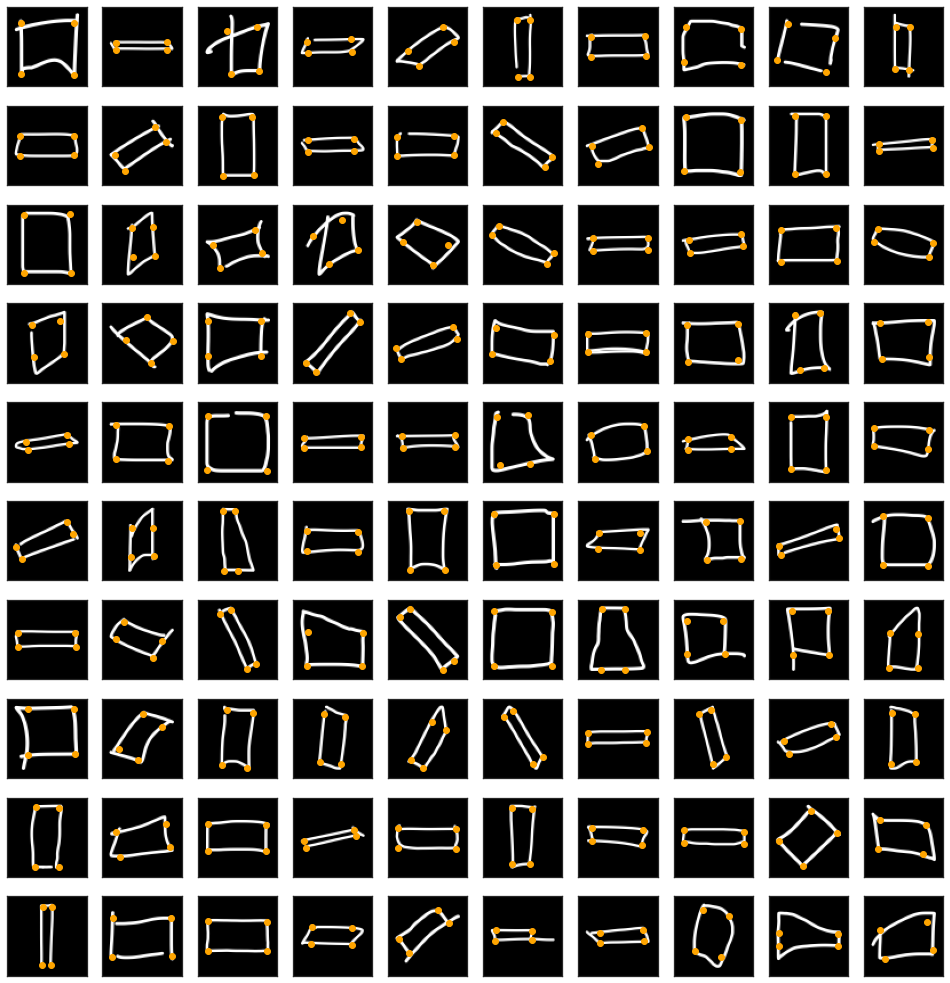

In [28]:
# Show random images from the Train Set + superimposed vertices
indexes = np.arange(len(Y_train))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images_with_vertices(X_train[first_random_indexes], Y_train[first_random_indexes])

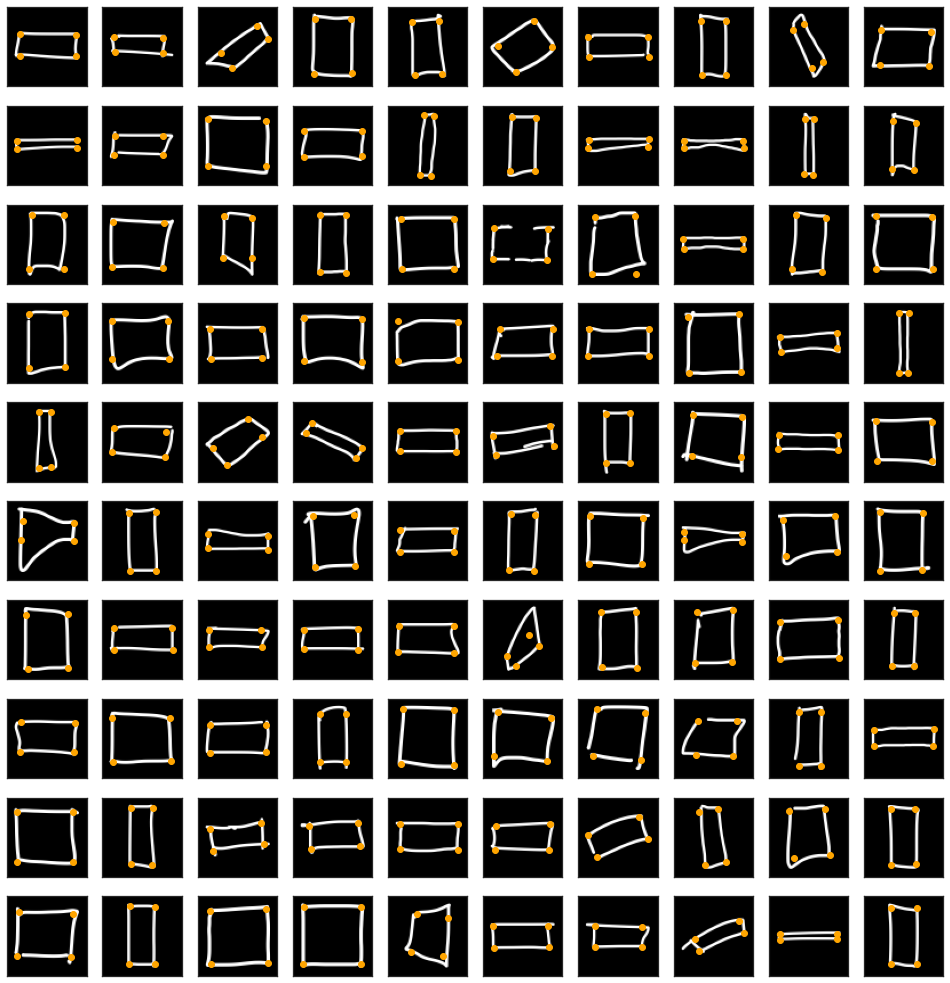

In [29]:
# Show random images from the Validation Set + superimposed vertices
indexes = np.arange(len(Y_val))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images_with_vertices(X_val[first_random_indexes], Y_val[first_random_indexes])

In [30]:
tf.keras.backend.clear_session()

## Define Deep Learning Model

In [31]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Flatten()(x)
    x = Dense(160)(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(nb_vertices * 2)(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [32]:
# select a model
model = get_model_cnn()

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 32)       

## Data augmentation: Full rotation, Flip vert. and Horiz with Targets modified

In [33]:
# Partition for the Generator
partition = []

nb_samples = X_train.shape[0]
print("nb_samples: ", nb_samples)

for i in range(nb_samples):
    partition.append(i)

nb_samples:  5386


For the generator, I create a custom Generator that does augmentation:
- Flips the images horizontally and vertically.
- Rotate the images 360 degres.
- **Adjust the labels (vertices) according the flips and rotation.**
- In particular, it manages the complexities of determining the first vertex.

This is an improved and more complex version of my generator described at: https://github.com/frobertpixto/tf_keras_generator_with_targets

Regarding **x_pos and y_pos**, this is the **anchor** used to finding the first vertex that I describe in more details
[here](https://github.com/frobertpixto/hand_drawn_shapes_dataset/blob/main/processing/find_vertices/README.md).

In [34]:
batch_size = 128
hds_gen = HdsDataGenerator(partition, X_train, Y_train, batch_size=batch_size,
                           n_vertices=nb_vertices,
                           x_pos=anchor_x,
                           y_pos=anchor_y)

## Define the optimizer

In [35]:
optimizer = Adam(lr=4e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

# Compile the model

In [36]:
model.compile(optimizer = optimizer , loss = "mean_squared_error")

# Set a learning rate callback

In [37]:
# when running for 1000 epoch, the reduction must be very slow.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=25,
                                            verbose=1,
                                            factor=0.90, 
                                            mode='min',
                                            min_delta=0.0000001,
                                            min_lr=0.000000001)


# Fit the model with data Augmentation

In [38]:
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy/loss curve, cleaning the graphs
epochs = 6
history = model.fit(x=hds_gen,
                    epochs = epochs, validation_data = (X_val,Y_val),
                    verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/6
42/42 [==============================] - 7s 169ms/step - loss: 0.2323 - val_loss: 0.1081
Epoch 2/6
42/42 [==============================] - 7s 166ms/step - loss: 0.0151 - val_loss: 0.0791
Epoch 3/6
42/42 [==============================] - 7s 168ms/step - loss: 0.0119 - val_loss: 0.0712
Epoch 4/6
42/42 [==============================] - 7s 172ms/step - loss: 0.0110 - val_loss: 0.0475
Epoch 5/6
42/42 [==============================] - 7s 167ms/step - loss: 0.0101 - val_loss: 0.0314
Epoch 6/6
42/42 [==============================] - 7s 172ms/step - loss: 0.0092 - val_loss: 0.0398


In [39]:
# Fit and Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True)

best_epoch_results = ShowBestEpochResult(on_param='val_loss', show_params=['val_loss', 'loss'], mode='min')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs  = 200 #1000
history = model.fit(x=hds_gen,
                      epochs = epochs, validation_data = (X_val,Y_val),
                      verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                      callbacks=callbacks_list)

Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 0.0081
Epoch 00001: val_loss improved from inf to 0.03498, saving model to ../saved_models/rectangle1.model.h5
42/42 [==============================] - 7s 170ms/step - loss: 0.0081 - val_loss: 0.0350
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 0.0086
Epoch 00002: val_loss did not improve from 0.03498
42/42 [==============================] - 7s 174ms/step - loss: 0.0086 - val_loss: 0.0419
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00003: val_loss improved from 0.03498 to 0.02287, saving model to ../saved_models/rectangle1.model.h5
42/42 [==============================] - 7s 168ms/step - loss: 0.0074 - val_loss: 0.0229
Epoch 4/200
42/42 [==============================] - ETA: 0s - loss: 0.0078
Epoch 00004: val_loss improved from 0.02287 to 0.01950, saving model to ../saved_models/rectangle1.model.h5
42/42 [==============================] - 7s 167ms/step - l

Epoch 36/200
42/42 [==============================] - ETA: 0s - loss: 0.0047
Epoch 00036: val_loss did not improve from 0.00117
42/42 [==============================] - 7s 167ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 37/200
42/42 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00037: val_loss did not improve from 0.00117
42/42 [==============================] - 7s 167ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 38/200
42/42 [==============================] - ETA: 0s - loss: 0.0043
Epoch 00038: val_loss did not improve from 0.00117
42/42 [==============================] - 7s 167ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 39/200
42/42 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00039: val_loss did not improve from 0.00117
42/42 [==============================] - 7s 166ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 40/200
42/42 [==============================] - ETA: 0s - loss: 0.0042
Epoch 00040: val_loss did not improve from 0.00117
42/4

Epoch 73/200
42/42 [==============================] - ETA: 0s - loss: 0.0034
Epoch 00073: val_loss did not improve from 0.00086
42/42 [==============================] - 7s 166ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 74/200
42/42 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00074: val_loss did not improve from 0.00086
42/42 [==============================] - 7s 163ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 75/200
42/42 [==============================] - ETA: 0s - loss: 0.0036
Epoch 00075: val_loss did not improve from 0.00086
42/42 [==============================] - 7s 165ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 76/200
42/42 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00076: val_loss did not improve from 0.00086
42/42 [==============================] - 7s 168ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 77/200
42/42 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00077: val_loss did not improve from 0.00086
42/4

42/42 [==============================] - ETA: 0s - loss: 0.0034
Epoch 00110: val_loss did not improve from 0.00078
42/42 [==============================] - 7s 165ms/step - loss: 0.0034 - val_loss: 9.2038e-04
Epoch 111/200
42/42 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00111: val_loss did not improve from 0.00078
42/42 [==============================] - 7s 167ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 112/200
42/42 [==============================] - ETA: 0s - loss: 0.0029
Epoch 00112: val_loss did not improve from 0.00078
42/42 [==============================] - 7s 167ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 113/200
42/42 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00113: val_loss did not improve from 0.00078
42/42 [==============================] - 7s 165ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 114/200
42/42 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00114: val_loss did not improve from 0.00078
42/42 [==

Epoch 147/200
42/42 [==============================] - ETA: 0s - loss: 0.0029
Epoch 00147: val_loss improved from 0.00065 to 0.00062, saving model to ../saved_models/rectangle1.model.h5
42/42 [==============================] - 7s 167ms/step - loss: 0.0029 - val_loss: 6.1978e-04
Epoch 148/200
42/42 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00148: val_loss did not improve from 0.00062
42/42 [==============================] - 7s 165ms/step - loss: 0.0027 - val_loss: 8.3414e-04
Epoch 149/200
42/42 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00149: val_loss did not improve from 0.00062
42/42 [==============================] - 7s 166ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 150/200
42/42 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00150: val_loss did not improve from 0.00062
42/42 [==============================] - 7s 165ms/step - loss: 0.0025 - val_loss: 8.7453e-04
Epoch 151/200
42/42 [==============================] - ETA:

Epoch 183/200
42/42 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00183: val_loss did not improve from 0.00052
42/42 [==============================] - 7s 168ms/step - loss: 0.0026 - val_loss: 5.7217e-04
Epoch 184/200
42/42 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00184: val_loss did not improve from 0.00052
42/42 [==============================] - 7s 166ms/step - loss: 0.0025 - val_loss: 7.6046e-04
Epoch 185/200
42/42 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00185: val_loss did not improve from 0.00052
42/42 [==============================] - 7s 165ms/step - loss: 0.0025 - val_loss: 7.9703e-04
Epoch 186/200
42/42 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00186: val_loss did not improve from 0.00052
42/42 [==============================] - 7s 167ms/step - loss: 0.0027 - val_loss: 6.5272e-04
Epoch 187/200
42/42 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00187: val_loss did not impr

## Plot the loss curves for training and validation

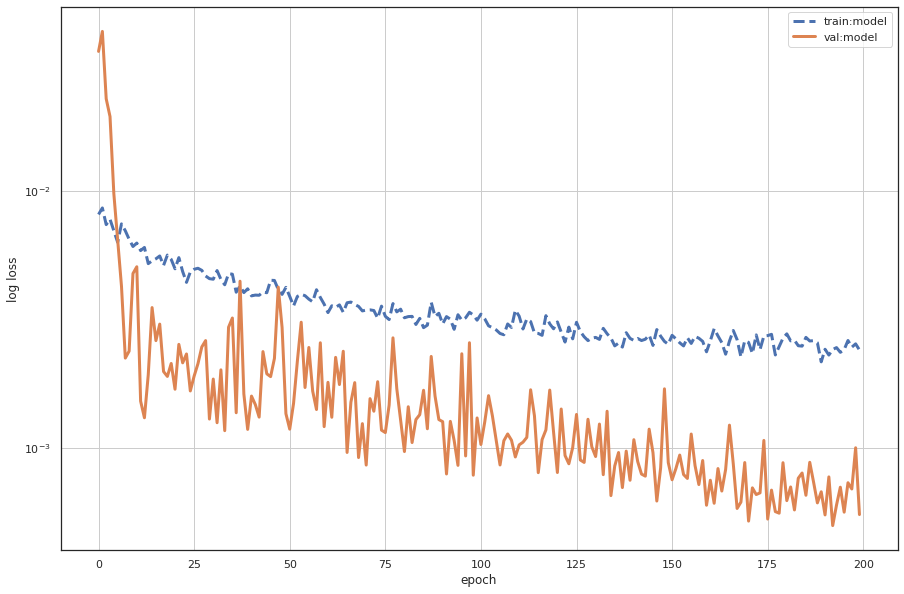

In [40]:
plt.figure(figsize=(15,10))
plot_loss(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

## Delete the existing model + Load the best one

In [41]:
# deletes the existing model
del model

# Load last saved model
model = load_model(model_name + ".h5")

In [42]:
Y_val_pred = model.predict(X_val)

In [43]:
# Labels are vertices: x1, y1, x2, y2, x3, y3, y4, y4
# Where:
# - (0, 0) is the top left corner of the image
# - (1, 1) is the bottom right corner of the image
print("Y_val shape: ", Y_val.shape)
print("Y_val_pred shape: ", Y_val_pred.shape)
print("Real Label example: ", Y_val[0])
print("Prediction example: ", Y_val_pred[0])

Y_val shape:  (1391, 8)
Y_val_pred shape:  (1391, 8)
Real Label example:  [0.28 0.87 0.27 0.13 0.77 0.12 0.78 0.88]
Prediction example:  [0.2737454  0.8710587  0.2926767  0.12606522 0.7439078  0.12327386
 0.72637165 0.882357  ]


# Calculate Dice accuracy for the whole Validation set

In [44]:
dice_val = calculate_Dice_for_set(Y_val, Y_val_pred, nb_vertices)
print(f"Validation Accuracy(Dice): {dice_val}.")

Validation Accuracy(Dice): 0.9255983537095772.


In [45]:
def plot_sample_with_pred(X, y, pred,axs):
    axs.imshow(X.reshape(image_size, image_size),cmap="gray") # Shape
    axs.scatter(image_size*y[0::2], image_size*y[1::2],c='orange') # Real Vertices
    axs.scatter(image_size*pred[0::2], image_size*pred[1::2],c='green') # Predicted Vertices

# Validation set predictions - Visualization

<ipython-input-46-6c45d09a7f7e>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])


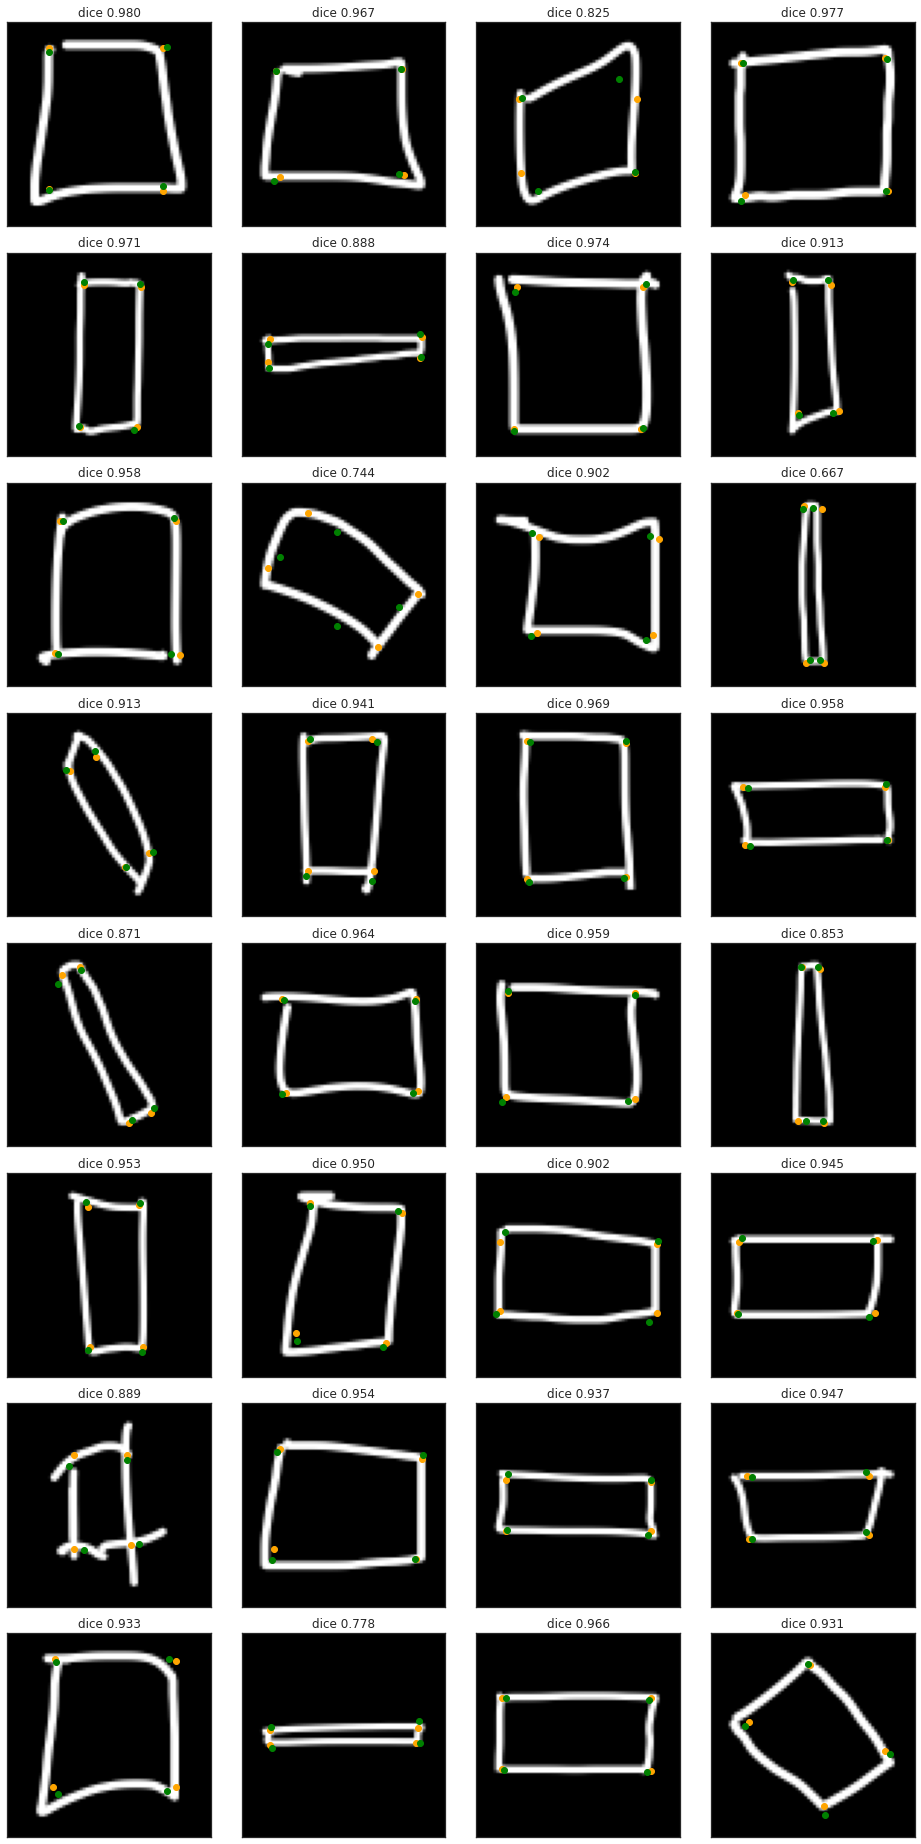

In [46]:
fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01,
                    left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
count = 1
for irow in range(nb_pictures):
    ipic = np.random.choice(X_val.shape[0])
    ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])        
    plot_sample_with_pred(X_val[ipic], Y_val[ipic], Y_val_pred[ipic], ax)

    dice = calculate_Dice(Y_val[ipic], Y_val_pred[ipic], nb_vertices=nb_vertices)
    ax.set_title("dice {:5.3f}".format(dice))
    count += 1
plt.show()

In [47]:
#TODO Display the 32 worst RMSE images

## Predict for the test set

In [48]:
## Prepare the Test set
test_X = test_dict['test_data']
test_y = test_dict['test_labels']
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1, image_size,image_size, 1)
Y_test    = test_y 
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (179, 70, 70)
test_y shape:  (179, 8)
X_test shape:  (179, 70, 70, 1)
Y_test shape:  (179, 8)


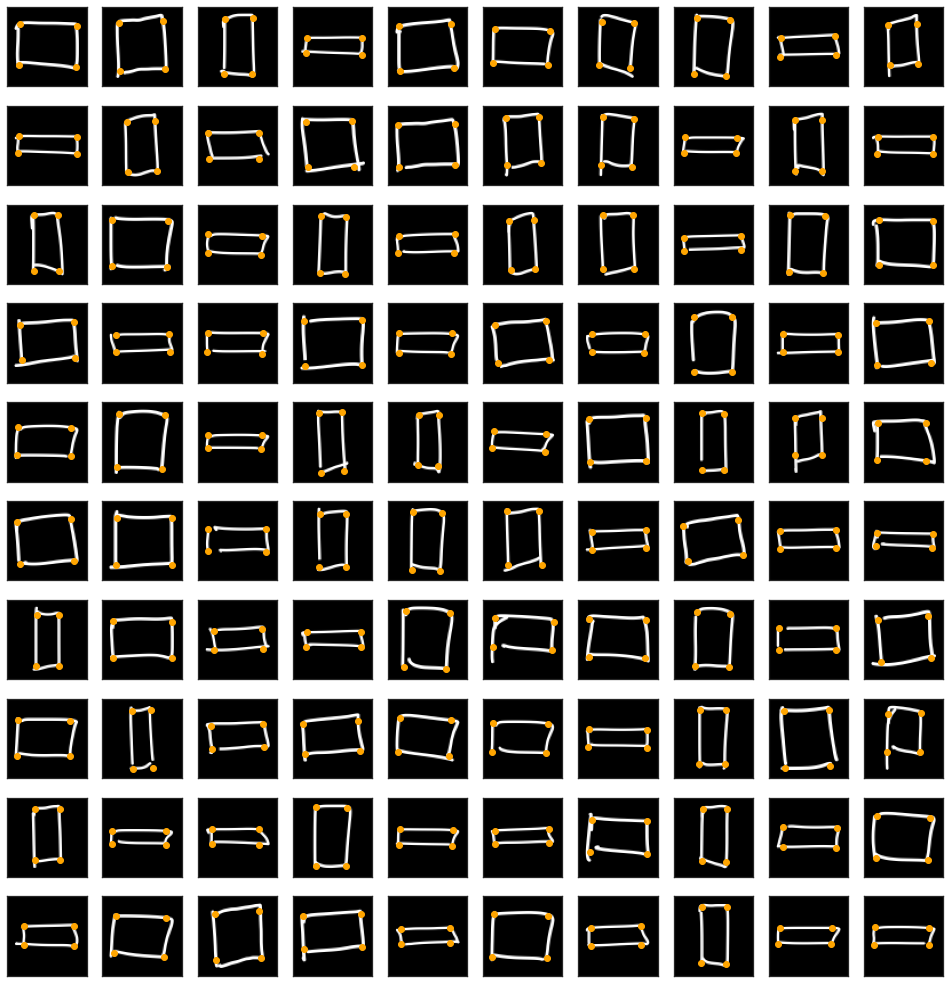

In [49]:
# Show random images from the Test Set + superimposed vertices
indexes = np.arange(len(Y_test))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images_with_vertices(X_test[first_random_indexes], Y_test[first_random_indexes])

In [50]:
test_loss = model.evaluate(X_test, Y_test)
print("test_loss: ", test_loss)

6/6 [==============================] - 0s 7ms/step - loss: 3.1359e-04
test_loss:  0.0003135905717499554


In [51]:
Y_test_pred = model.predict(X_test)

In [52]:
print("Y_pred shape: ", Y_test_pred.shape)
Y_test_pred[0:2, :]

Y_pred shape:  (179, 8)


array([[0.31746125, 0.7184948 , 0.3425393 , 0.18753237, 0.6770534 ,
        0.22161248, 0.6431824 , 0.745907  ],
       [0.13587184, 0.6633098 , 0.17241928, 0.25277445, 0.87520397,
        0.30944526, 0.8343146 , 0.72431016]], dtype=float32)

# Calculate Dice accuracy for the whole Test set

In [53]:
dice_val = calculate_Dice_for_set(Y_test, Y_test_pred, nb_vertices)
print(f"Validation Accuracy(Dice): {dice_val}.")

Validation Accuracy(Dice): 0.9501481269816501.


# Test set predictions - Visualization

<ipython-input-54-033545e13e56>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])


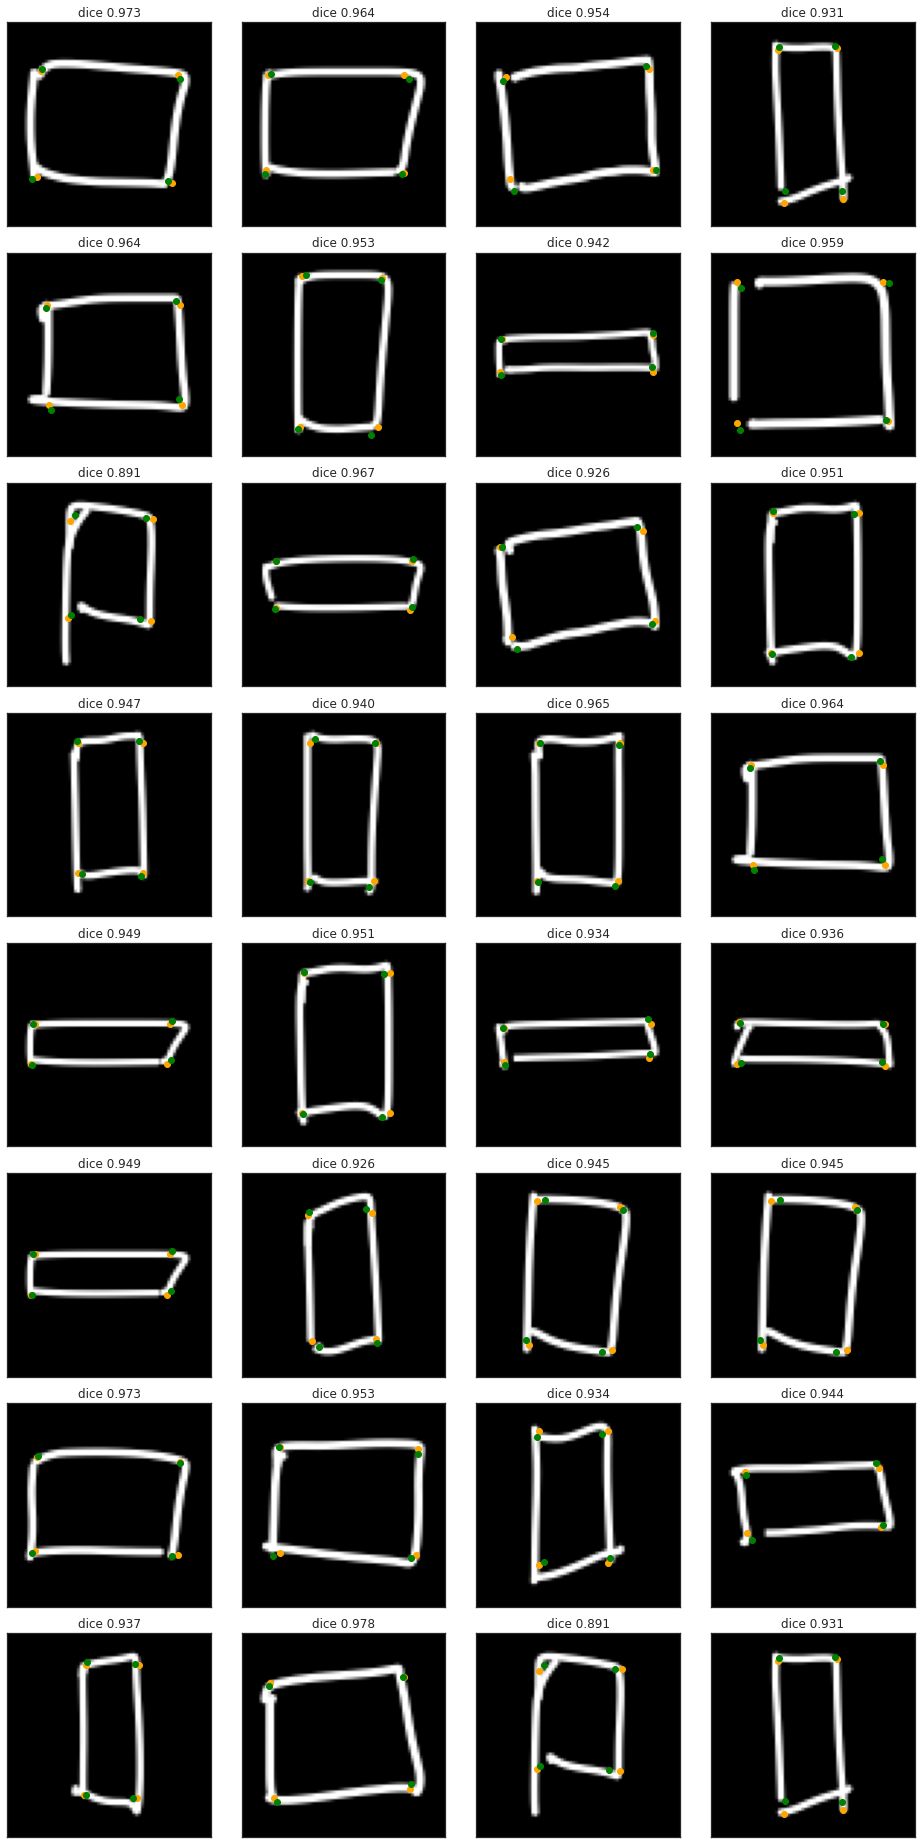

In [54]:
fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01,
                    left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
count = 1
for irow in range(nb_pictures):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])        
    plot_sample_with_pred(X_test[ipic], Y_test[ipic], Y_test_pred[ipic], ax)
    
    try:
        dice = calculate_Dice(Y_test[ipic], Y_test_pred[ipic], nb_vertices=nb_vertices)
        ax.set_title("dice {:5.3f}".format(dice))
    except Exception as e:
        print(f"Cannot compute Dice for shape: {i}.")    
        
    count += 1
plt.show()

# Conclusions
Accuracy is generally good. We see that:
- Most are very close to the real labels.
- Some are off and between to real labels. I describe that issue [here](https://github.com/frobertpixto/hand_drawn_shapes_dataset/blob/main/processing/find_vertices/README.md).


Regarding the loss, we have:  
- BestEpochResult. Epoch: 193, val_loss: **0.00050**

For Mix on pix, when training for 1000 epoch, I had:  
- BestEpochResult. Epoch: 977, val_loss: **0.00021**  

The model was definitively useful in [Mix on Pix](https://apps.apple.com/us/app/mix-on-pix-text-on-photos/id633281586).

## TensorFlow Lite Notes
When creating a TensorFlow Lite model with quantization, accuracy can be a tiny bit lower, but the model size is 25% of the original. That's super important when running directly in a mobile app.

In [55]:
datetime.datetime.now()

datetime.datetime(2022, 5, 28, 14, 39, 9, 83901)